# LangGraph 챗봇 구축

먼저 `LangGraph`를 사용해 간단한 챗봇을 만들어 보겠습니다. 이 챗봇은 사용자 메시지에 직접 응답할 것입니다. 비록 간단하지만, `LangGraph`로 구축하는 핵심 개념을 설명할 것입니다. 이 섹션이 끝나면 기본적인 챗봇을 구축하게 될 것입니다.

`StateGraph`를 생성하는 것으로 시작하십시오. `StateGraph` 객체는 챗봇의 구조를 "상태 기계(State Machine)"로 정의합니다.

`nodes`를 추가하여 챗봇이 호출할 수 있는 `llm`과 함수들을 나타내고, `edges`를 추가하여 봇이 이러한 함수들 간에 어떻게 전환해야 하는지를 지정합니다.

In [ ]:
# API 키를 환경변수로 관리하기 위한 설정 파일
# LangSmith 추적을 설정합니다.
import os
from dotenv import load_dotenv

# API 키 정보 로드
dotenv_path = "/mnt/data1/work/LangChain_Study/.env"
load_dotenv(dotenv_path=dotenv_path)

os.environ["LANGSMITH_PROJECT"]="CH17-LangGrapgh-Modules"

# Step-by-Step 개념 이해하기!

## STEP 1. 상태(State) 정의

In [2]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict) :
    # 메시지 정의(list type이며 add_messages 함수를 사용하여 메시지를 추가)
    messages: Annotated[list, add_messages]

## STEP 2. 노드(Node) 정의

다음으로 `chatbot` 노드를 추가합니다.

노드는 작업의 단위를 나타내며, 일반적으로 정규 Python 함수입니다.

In [3]:
from langchain_ollama import ChatOllama

""" LLM 정의 """
model = "gemma2:27b-instruct-q8_0"
llm = ChatOllama(model=model,
                 temperature=0.1,
                 num_predict=1024,
                 top_p=0.9,
)

""" 챗봇 함수 정의 """
def chatbot(state: State) :
    # 메시지 호출 및 반환
    return {"messages" : [llm.invoke(state["messages"])]}

## STEP 3. 그래프(Graph) 정의, 노드 추가

In [4]:
""" 그래프 생성 """
graph_builder = StateGraph(State)

""" 노드 이름, 함수 혹은 callable 객체를 인자로 받아 노드에 추가 """
graph_builder.add_node("chatbot", chatbot)

참고

- `chatbot` 노드 함수는 현재 `State`를 입력으로 받아 "messages"라는 키 아래에 업데이트된 `messages` 목록을 포함하는 사전(TypedDict)을 반환합니다.

- `State`의 `add_messages` 함수는 이미 상태에 있는 메시지에 llm의 응답 메시지를 추가합니다.

## STEP 4. 그래프 엣지(Edge) 추가

다음으로, `START` 지점을 추가하세요. `START`는 그래프가 실행될 때마다 작업을 시작할 위치입니다.

In [5]:
""" 시작 노드에서 챗봇 노드로의 엣지 추가 """
graph_builder.add_edge(START, "chatbot")

마찬가지로, `END` 지점을 설정하십시오. 이는 그래프 흐름의 종료(끝 지점)을 나타냅니다.

In [6]:
""" 그래프에 엣지 추가 """
graph_builder.add_edge("chatbot", END)

## STEP 5. 그래프 컴파일(compile)

마지막으로, 그래프를 실행할 수 있어야 합니다. 이를 위해 그래프 빌더에서 "`compile()`"을 호출합니다. 이렇게 하면 상태에서 호출할 수 있는 "`CompiledGraph`"가 생성됩니다.

In [7]:
""" 그래프 컴파일 """
graph = graph_builder.compile()

## STEP 6. 그래프 시각화

이제 그래프를 시각화해봅시다.

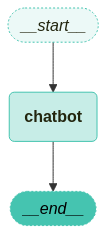

In [8]:
from langchain_teddynote.graphs import visualize_graph

""" 그래프 시각화 """
visualize_graph(graph)

## STEP 7. 그래프 실행

이제 챗봇을 실행해봅시다!

In [9]:
question = "대한민국 여행지 추천해줘"

""" 그래프 이벤트 스트리밍 """
for event in graph.stream({"messages" : [("user", question)]}) :
    # 이벤트 값 출력
    for value in event.values() :
        print("Assistant:", value["messages"][-1].content)

Assistant: 대한민국 여행지 추천을 위해 좀 더 자세한 정보가 필요해요! 😊

어떤 여행을 원하시나요? 

* **여행 스타일:**  액티비티, 휴식, 관광, 미식, 역사/문화 체험 등
* **여행 기간:** 며칠 동안 여행을 계획하고 계신가요?
* **여행 예산:** 저렴한 여행, 중급 여행, 고급 여행 중 어떤 것을 선호하시나요?
* **동반자:** 혼자, 친구, 연인, 가족과 함께 여행하시나요?
* **관심 분야:** 특별히 관심 있는 분야가 있으신가요? (예: K-POP, 드라마 촬영지, 자연, 예술 등)

이 정보를 알려주시면 취향에 맞는 최고의 여행지를 추천해드릴 수 있어요! ✨
